# Multi-task logistic regression for individual survival prediction
Multi-task logistic regression (MTLR) is a machine learning model for survival prediction. It overcomes many of the limitations of existing methods (e.g. the Cox proportional hazard model) by directly modelling the survival curve of each individual, allowing for more accurate individualised survival prediction. This notebook contains a PyTorch implementation of MTLR, together with experiments on simulated and real data. In the blog post (coming soon!), I will give the derivation and theoretical background for the model.

In [319]:
%matplotlib inline 
from math import sqrt, ceil
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, roc_auc_score
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from scipy.interpolate import interp1d
from tqdm import tqdm, trange

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

device = "cpu"

sns.set(context="poster", style="white")
plt.rcParams["figure.figsize"] = (10, 7)

## MTLR implementation
Quick remark on notation: subscripts (e.g. $x_k$) denote indexing over timepoints, while superscripts (like $y^{(j)}$) indicate indexing over datapoints.

First comes the MTLR likelihood implementation. You can find the original likelihood definition in [the original publication](https://papers.nips.cc/paper/4210-learning-patient-specific-cancer-survival-distributions-as-a-sequence-of-dependent-regressors). Briefly, the approach is to discretise the time axis into $K$ bins and fit a logistic regression model to predict the probability of event in each bin.

<center><img src="time_bins.png" width="600"> </center>

*[Image source](https://era.library.ualberta.ca/items/3deb4dd9-788d-4c61-94a5-d3ee6645f74f).*


The probability of event time $T$ falling in the bin $[\tau_{i-1}, \tau_i)$ given covariates $\mathbf{x}$ is modelled as:

$$
P(\tau_{i-1} \le T < \tau_i | \mathbf{x}, \boldsymbol{\theta}) = \frac{\exp(\sum_{k=i}^{K-1}\mathbf{x} \cdot \boldsymbol{\theta}_k + b_k)}{Z(\mathbf{x}, \boldsymbol{\Theta})},
$$

where $\boldsymbol{\theta}_k, b_k$ are the model parameters and $Z = \sum_{i=1}^K \exp(\sum_{k=i}^{K-1}\mathbf{x} \cdot \boldsymbol{\theta}_k + b_k)$ is the normalizing constant.

Here, we use the reformulation as softmax classifier (first derived [here](https://era.library.ualberta.ca/items/3deb4dd9-788d-4c61-94a5-d3ee6645f74f)), allowing for more efficient computation. Each uncensored instance is now assigned a single *class label*, which is represented as one-hot encoded binary vector. For instances censored at time $t_c$, we know that their true class label lies between $c_c$ and $c_K$, which is encoded as a binary vector with 1s at all indices $c-1 \le i \le K-1$. In this case, the 1s indicate the timepoints over which to marginalise. For example, if the time axis is split into 5 bins, an instance experiencing event in bin 3 (0-indexed) is encoded as `[0, 0, 0, 1, 0]`, and instance censored in bin 2 as `[0, 0, 1, 1, 1]`.

The log-likelihood for uncensored instances is similar to the standard softmax log-likelihood:

$$
L(\boldsymbol{\Theta}, \mathbf{x}, \mathbf{y}) = \sum_{k=i}^{K-1}(\mathbf{x} \cdot \boldsymbol{\theta}_k + b_k) - \log(Z(\mathbf{x}, \boldsymbol{\Theta})),
$$

where $i$ is the index of non-zero entry in $\mathbf{y}$.

For censored instances, we need to sum (marginalize) over all possible class probabilities:

$$
L(\boldsymbol{\Theta}, \mathbf{x}, \mathbf{y}) = \log(\sum_i \exp(\sum_{k=i}^{K-1}\mathbf{x} \cdot \boldsymbol{\theta}_k + b_k) - \log(Z(\mathbf{x}, \boldsymbol{\Theta})),
$$

where the sum is over all non-zero entries in $\mathbf{y}$.

Here, the summation is over all timepoints later than the censoring time $T_c$.

The full log-likelihood for a dataset $D = {(\mathbf{x}^{(j)}, y^{(j)})}_{j=1}^{N}$ with $N$ instances, $N_c$ of which are censored, is 

$$
L(\boldsymbol{\Theta}, D) =
\sum_{j=1}^{N-N_c}\sum_{k=1}^{K-1}(\mathbf{x}^{(j)} \cdot \boldsymbol{\theta}_k + b_k)\mathbf{y}_k^{(j)} + 
\sum_{j=N_c}^{N}\log(\sum_{t_k > T_c^{(j)}} \exp(\sum_{k=1}^{K-1}\mathbf{x}^{(j)} \cdot \boldsymbol{\theta}_k + b_k)
- \sum_{j=1}^{N}\log(Z(\mathbf{x}^{(j)}, \boldsymbol{\Theta})) + \frac{C_1}{2}\sum_{k=1}^{K-1}\Vert\boldsymbol{\theta}_k\Vert^2.
$$

$C_1$ is a hyperparameter determining the strength of $L_2$ regularisation, which also controls the smoothness of predicted survival curves.

In [328]:
class MTLR(nn.Module):
    """Multi-task logistic regression for individualised
    survival prediction.
    
    The MTLR time-logits are computed as:
    `z = sum_k x^T w_k + b_k`,
    where `w_k` and `b_k` are learnable weights and biases for each time interval.
    
    Note that a slightly more efficient reformulation is used here, first proposed
    in [2]_.
    
    References
    ----------
    ..[1] C.-N. Yu et al., ‘Learning patient-specific cancer survival distributions 
    as a sequence of dependent regressors’, in Advances in neural information processing systems 24,
    2011, pp. 1845–1853.
    ..[2] P. Jin, ‘Using Survival Prediction Techniques to Learn Consumer-Specific Reservation Price Distributions’,
    Master's thesis, University of Alberta, Edmonton, AB, 2015.
    """
    def __init__(self, in_features, num_time_bins):
        """Initialises the module.
        
        Parameters
        ----------
        in_features : int
            Number of input features.
        num_time_bins : int
            The number of bins to divide the time axis into.
        """
        super().__init__()
        self.in_features = in_features
        self.num_time_bins = num_time_bins

        weight = torch.zeros(self.in_features,
                             self.num_time_bins-1,
                             dtype=torch.float)
        bias = torch.zeros(self.num_time_bins-1)
        self.mtlr_weight = nn.Parameter(weight)
        self.mtlr_bias = nn.Parameter(bias)
        
        # `G` is the coding matrix from [2]_ used for fast summation.
        # When registered as buffer, it will be automatically
        # moved to the correct device and stored in saved
        # model state.
        self.register_buffer("G", 
                             torch.tril(torch.ones(self.num_time_bins-1, 
                                                   self.num_time_bins, requires_grad=True)))
        self.reset_parameters()

    def forward(self, x):
        """Performs a forward pass on a batch of examples.
        
        Parameters
        ----------
        x : torch.Tensor, shape (num_samples, num_features)
            The input data.
        
        Returns
        -------
        torch.Tensor, shape (num_samples, num_time_bins)
            The predicted time logits.
        """
        out = torch.matmul(x, self.mtlr_weight) + self.mtlr_bias
        return torch.matmul(out, self.G)
    
    def reset_parameters(self):
        """Resets the model parameters."""
        nn.init.xavier_normal_(self.mtlr_weight)
        nn.init.constant_(self.mtlr_bias, 0.)


def masked_logsumexp(x, mask, dim=-1):
    """Computes logsumexp over elements of a tensor specified by a mask in a numerically stable way.
    
    Parameters
    ----------
    x : torch.Tensor
        The input tensor.
    mask : torch.Tensor
        A tensor with the same shape as `x` with 1s in positions that should
        be used for logsumexp computation and 0s everywhere else.
    dim : int
        The dimension of `x` over which logsumexp is computed. Default -1 uses
        the last dimension.
    
    Returns
    -------
    torch.Tensor
        Tensor containing the logsumexp of each row of `x` over `dim`.
    """
    max_val, _ = (x * mask).max(dim=dim)
    max_val = torch.clamp_min(max_val, 0)
    return torch.log(torch.sum(torch.exp(x - max_val.unsqueeze(dim)) * mask, dim=dim)) + max_val


def mtlr_neg_log_likelihood(logits, target, model, C1=1, C2=1, l1=0, average=False):
    """Computes the negative log-likelihood of a batch of model predictions.
    
    Parameters
    ----------
    logits : torch.Tensor, shape (num_samples, num_time_bins)
        Tensor with the time-logits (as returned by the MTLR module) for one instance
        in each row.
    target : torch.Tensor, shape (num_samples, num_time_bins)
        Tensor with the encoded ground truth survival.
        
    Returns
    -------
    torch.Tensor
        The predicted survival curves for each row in `pred` at timepoints used during training.
    """
    censored = target.sum(dim=1) > 1
    if censored.any():
        nll_censored = masked_logsumexp(logits[censored], target[censored]).sum()
    else:
        nll_censored = 0.
    if (~censored).any():
        nll_uncensored = (logits[~censored] * target[~censored]).sum()
    else:
        nll_uncensored = 0.
    
    # the normalising constant
    norm = torch.logsumexp(logits, dim=1).sum()
    nll_total = -(nll_censored + nll_uncensored - norm)
    if average:
        nll_total = nll_total / target.size(0)
    weights = [v for k, v in model.named_parameters() if "mtlr_weight" in k][0]
    nll_total += C1/2 * torch.sum(weights**2)
    nll_total += C2/2 * torch.sum((weights[:, 1:] - weights[:, :-1])**2)
    nll_total += l1/2 * torch.sum(torch.abs(weights))
    return nll_total


def mtlr_survival(logits):
    """Generates predicted survival curves from predicted logits.
    
    Parameters
    ----------
    logits : torch.Tensor
        Tensor with the time-logits (as returned by the MTLR module) for one instance
        in each row.
        
    Returns
    -------
    torch.Tensor
        The predicted survival curves for each row in `pred` at timepoints used during training.
    """
    # TODO: do not reallocate G in every call
    G = torch.tril(torch.ones(logits.size(1), logits.size(1))).to(logits.device)
    density = torch.softmax(logits, dim=1)
    return torch.matmul(density, G)


def mtlr_survival_at_times(logits, train_times, pred_times):
    """Generates predicted survival curves at arbitrary timepoints using linear interpolation.
    
    This function uses scipy.interpolate internally and returns a Numpy array, in contrast
    with `mtlr_survival`.
    
    Parameters
    ----------
    logits : torch.Tensor 
        Tensor with the time-logits (as returned by the MTLR module) for one instance
        in each row.
    train_times : Tensor or ndarray
        Time bins used for model training. Must have the same length as the first dimension
        of `pred`.
    pred_times : np.ndarray
        Array of times used to compute the survival curve.
    
    Returns
    -------
    np.ndarray
        The survival curve for each row in `pred` at `pred_times`. The values are linearly interpolated
        at timepoints not used for training.
    """
    with torch.no_grad():
        surv = mtlr_survival(logits).cpu().numpy()
    interpolator = interp1d(train_times, surv)
    return interpolator(pred_times)


def mtlr_hazard(logits):
    """Computes the hazard function from MTLR predictions.
    
    The hazard function is the instantenous rate of failure, i.e. roughly
    the risk of event at each time interval. It's computed using
    `h(t) = f(t) / S(t)`,
    where `f(t)` and `S(t)` are the density and survival functions at t, respectively.
    
    Parameters
    ----------
    logits : torch.Tensor
        The predicted logits as returned by the `MTLR` module.
        
    Returns
    -------
    torch.Tensor
        The hazard function at each time interval in `y_pred`.
    """
    return torch.softmax(logits, dim=1)[:, :-1] / (mtlr_survival(logits) + 1e-15)[:, 1:]


def mtlr_risk(logits):
    """Computes the overall risk of event from MTLR predictions.
    
    The risk is computed as the time integral of the cumulative hazard,
    as defined in [1]_.
    
    Parameters
    ----------
    logits : torch.Tensor
        The predicted logits as returned by the `MTLR` module.
        
    Returns
    -------
    torch.Tensor
        The predicted overall risk.
    """
    hazard = mtlr_hazard(logits)
    return torch.sum(hazard.cumsum(1), dim=1)

Next come a few utility functions.

In [329]:
# utility functions
def encode_survival(time, event, bins):
    """Encodes survival time and event indicator in the format
    required for MTLR training.
    
    For uncensored instances, one-hot encoding of binned survival time
    is generated. Censoring is handled differently, with all possible
    values for event time encoded as 1s. For example, if 5 time bins are used,
    an instance experiencing event in bin 3 is encoded as [0, 0, 0, 1, 0], and 
    instance censored in bin 2 as [0, 0, 1, 1, 1]. Note that an additional
    'catch-all' bin is added, spanning the range `(bins.max(), inf)`.
    
    Parameters
    ----------
    time : np.ndarray
        Array of event or censoring times.
    event : np.ndarray
        Array of event indicators (0 = censored).
    bins : np.ndarray
        Bins used for time axis discretisation.

    Returns
    -------
    torch.Tensor
        Encoded survival times.
    """
    time = np.clip(time, 0, bins.max())
    bin_idxs = np.digitize(time, bins)
    # add extra bin [max_time, inf) at the end
    y = np.zeros((time.shape[0], bins.shape[0] + 1), dtype=np.int)
    for i, e in enumerate(event):
        bin_idx = bin_idxs[i]
        if e == 1:
            y[i, bin_idx] = 1
        else:
            y[i, bin_idx:] = 1
    return torch.tensor(y, dtype=torch.float)


def reset_parameters(model):
    """Resets the parameters of a PyTorch module and its children."""
    for m in model.modules():
        try:
            m.reset_parameters()
        except AttributeError:
            continue
    return model


def make_optimizer(model, lr, weight_decay, l2_reg):
    """Creates a PyTorch optimizer for MTLR training."""
    params_dict = dict(model.named_parameters())
    weights = [v for k, v in params_dict.items() if "mtlr" not in k and "bias" not in k]
    biases = [v for k, v in params_dict.items() if "bias" in k]
    mtlr_weights = [v for k, v in params_dict.items() if "mtlr_weight" in k]
    # Don't use weight decay on the biases and MTLR parameters, which have
    # their own separate L2 regularization
    optimizer = AdamW([
        {"params": weights},
        {"params": biases, "weight_decay": 0.},
        {"params": mtlr_weights, "weight_decay": l2_reg},
    ], lr=lr, weight_decay=weight_decay)
    return optimizer


def make_time_bins(times, num_bins=None, use_quantiles=True):
    """Creates the bins for survival time discretisation.
    
    By default, sqrt(num_observation) bins corresponding to the quantiles of 
    the survival time distribution are used, as in https://github.com/haiderstats/MTLR.
    
    Parameters
    ----------
    times : np.ndarray
        Array of survival times.
    num_bins : int, optional
        The number of bins to use. If None (default), sqrt(num_observations)
        bins will be used.
    use_quantiles : bool
        If True, the bin edges will correspond to quantiles of `times` (default).
        Otherwise, generates equally-spaced bins.
        
    Returns
    -------
    np.ndarray
        Array of bin edges.
    """
    if num_bins is None:
        num_bins = ceil(sqrt(len(times)))
    if use_quantiles:
        bins = np.unique(np.quantile(times, np.linspace(0, 1, num_bins)))
    else:
        bins = np.linspace(times.min(), times.max(), num_bins)
    return bins


def normalize(data, mean=None, std=None, skip_cols=[]):
    """Normalizes the columns of Pandas DataFrame to zero mean and unit
    standard deviation."""
    if mean is None:
        mean = data.mean(axis=0)
    if std is None:
        std = data.std(axis=0)
    if skip_cols is not None:
        mean[skip_cols] = 0
        std[skip_cols] = 1
    return (data - mean) / std, mean, std


# training functions
def train_mtlr(model, data_train, time_bins,
               num_epochs=1000, lr=.01, weight_decay=0.,
               C1=1., C2=1., l1=0, batch_size=None,
               verbose=True, device="cpu"):
    """Trains the MTLR model using minibatch gradient descent.
    
    Parameters
    ----------
    model : torch.nn.Module
        MTLR model to train.
    data_train : pd.DataFrame
        The training dataset. Must contain a `time` column with the
        event time for each sample and an `event` column containing
        the event indicator.
    num_epochs : int
        Number of training epochs.
    lr : float
        The learning rate.
    weight_decay : float
        Weight decay strength for all parameters *except* the MTLR
        weights. Only used for Deep MTLR training.
    l2_reg : float
        L2 regularization (weight decay) strenght for MTLR parameters.
    batch_size : int
        The batch size.
    verbose : bool
        Whether to display training progress.
    device : str
        Device name or ID to use for training.
        
    Returns
    -------
    torch.nn.Module
        The trained model.
    """
    x = torch.tensor(data_train.drop(["time", "event"], axis=1).values, dtype=torch.float)
    y = encode_survival(data_train["time"], data_train["event"], time_bins)
    optimizer = make_optimizer(model, lr, weight_decay, C1)
    reset_parameters(model)
    model = model.to(device)
    model.train()
    train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)
    
    pbar = trange(num_epochs, disable=not verbose)
    for i in pbar:
        for xi, yi in train_loader:
            xi, yi = xi.to(device), yi.to(device)
            y_pred = model(xi)
            loss = mtlr_neg_log_likelihood(y_pred, yi, model, 0, C2, l1, average=True)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pbar.set_description(f"[epoch {i+1: 4}/{num_epochs}]")
        pbar.set_postfix_str(f"loss = {loss.item():.4f}")
    model.eval()
    return model


def train_mtlr_cv(model, data_train, time_bins, cv=3, l2_reg_vals=None, verbose=True, device="cpu", **kwargs):
    """Trains the MTLR model using minibatch gradient descent, 
    determining the optimal L2 regularization strength with K-fold 
    cross-validation.
    
    Parameters
    ----------
    model : torch.nn.Module
        MTLR model to train.
    data_train : pd.DataFrame
        The training dataset. Must contain a `time` column with the
        event time for each sample and an `event` column containing
        the event indicator.
    cv : int
        The number of cross-validation splits to use.
    l2_reg_vals : float, optional
        L2 regularization (weight decay) values to test. If None (default),
        search over `np.logspace(-2, 3, 6)`.
    verbose : bool
        Whether to display training progress.
    device : str
        Device name or ID to use for training.
    kwargs
        Additional keyword arguments passed to `train_mtlr`.

    Returns
    -------
    torch.nn.Module
        The trained model.
    """
    if l2_reg_vals is None:
        l2_reg_vals = np.logspace(-2, 3, 6)
        
    kfold = KFold(n_splits=cv)
    nll_vals = defaultdict(list)
    for l2_reg in l2_reg_vals:
        pbar = tqdm(kfold.split(data_train),
                    total=cv,
                    disable=not verbose,
                    desc=f"testing l2_reg = {l2_reg:9}")
        for train_idx, val_idx in pbar:
            train_fold, val_fold = data_train.iloc[train_idx], data_train.iloc[val_idx]
            time_val, event_val = data_train.iloc[val_idx]["time"], data_train.iloc[val_idx]["event"]
            x_val = torch.tensor(val_fold.drop(["time", "event"], axis=1).values,
                                 dtype=torch.float, device=device)
            y_val = encode_survival(time_val, event_val, time_bins).to(device)
            model = train_mtlr(model, train_fold, time_bins, C1=l2_reg, C2=1, device=device, verbose=False, **kwargs)
            with torch.no_grad():
                val_nll = mtlr_neg_log_likelihood(model(x_val), y_val, model, l2_reg, 1)
                nll_vals[l2_reg].append(val_nll.item())
            pbar.set_postfix_str(f"val nll = {val_nll.item():.2f}")
    
    # Choose regularization parameter with the lowest negative log-likelihood
    best_l2_reg = min(nll_vals, key=lambda k: sum(nll_vals[k]) / cv)
    
    if verbose:
        print(f"training with l2_reg = {best_l2_reg}")
    
    model = train_mtlr(model, data_train, time_bins, C1=best_l2_reg, C2=1, device=device, verbose=verbose, **kwargs)
    return model

## Experiments with simulated data

Let's first see how MTLR performs on a simulated dataset. We'll generate a dataset with 10 Gaussian features and linear, constant hazard. The hazard is given by:

$$
h(\mathbf{x}) = x_1 + 2x_2
$$

and the survival times are generated randomly from an exponential distribution:

$$
T \sim \mathrm{Exp}(\lambda_{\mathrm{base}}\exp(h(\mathbf{x})).
$$

Note that only 2 of the variables correlate with the survival time and the rest are noise. We also adjust the censoring time such that approximately 10% of the observations are censored.

In [330]:
def make_synthetic_data(n_samples=8000, n_noise_features=8, base_hazard=.1, percent_censor=.1):
    """Generates a synthetic survival dataset with linear hazard."""
    x = np.random.standard_normal((n_samples, n_noise_features + 2))
    hazards = x[:, 0] + 2 * x[:, 1]
    event_time = np.random.exponential(1 / (base_hazard * np.exp(hazards)))
    censor_time = np.quantile(event_time, 1 - percent_censor)

    time = np.minimum(event_time, censor_time)
    event = (event_time < censor_time).astype(np.int)

    return pd.DataFrame({
        "time": time,
        "event": event,
        **{f"x{i+1}": x[:, i] for i in range(x.shape[1])}
    })

In [370]:
data = make_synthetic_data()

In [395]:
# prepare data
data_train, data_test = train_test_split(data, test_size=.25, random_state=42)
time_bins = make_time_bins(data_train["time"])
num_time_bins = len(time_bins) + 1

# fit MTLR model 
mtlr = MTLR(in_features=10, num_time_bins=num_time_bins)
mtlr = train_mtlr(mtlr, data_train, time_bins, num_epochs=100, C1=1, C2=1, l1=.1,
                  lr=.005, batch_size=512, verbose=True, device=device)

with torch.no_grad():
    pred = mtlr(torch.tensor(data_test.drop(["time", "event"], axis=1).values, dtype=torch.float, device=device))
    pred_survival = mtlr_survival(pred).cpu().numpy()
    pred_risk = mtlr_risk(pred).cpu().numpy()

[epoch  100/100]: 100%|██████████| 100/100 [00:06<00:00, 15.73it/s, loss = 3.9875]


We can check the model's [concordance index](https://stats.stackexchange.com/questions/29815/how-to-interpret-the-output-for-calculating-concordance-index-c-index) to make sure it has converged.

In [396]:
# Note that the CI function expects the predictions to be higher for
# longer survivors, which can be achieved by flipping the sign of the risk.
ci = concordance_index(data_test["time"], -pred_risk, event_observed=data_test["event"])
print(f"CI = {ci:.2f}")

CI = 0.84


Since the MTLR model associates a parameter with each time bin, we can plot the trained parameter values over time to see how the importance of each feature changes over time.

In [444]:
def plot_weights(weights, time_bins, feature_names, n=5):
    """Plot MTLR model parameters over time."""
    top_idxs = torch.argsort(weights.abs().sum(1), descending=True)[:n]
    fig, ax = plt.subplots()
    for i in top_idxs:
        ax.plot(np.pad(time_bins, (1, 0))[:-1], weights[i], label=feature_names[i])
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Weight")
    ax.axhline(0, c="k", linestyle="--")
    fig.legend()
    return ax

<AxesSubplot:xlabel='Time (days)', ylabel='Weight'>

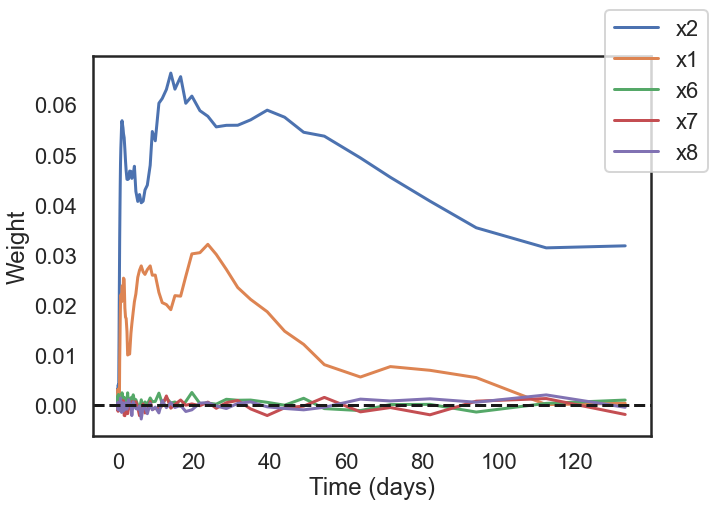

In [398]:
feature_names = data.drop(["time", "event"], axis=1).columns
plot_weights(mtlr.mtlr_weight.detach().cpu(), time_bins, feature_names)

From the plot, we can see that the model is able to correctly identify the 2 important variables ($x_1$ and $x_2$) while assigning low weights to the noise variables. Furthermore, the weights are more or less constant over time (reflecting the constant hazard) and the weight for $x_2$ is approximately twice the weight of $x_1$, as it should be. This gives us reasonable confidence that our MTLR implementation is correct!

## Comparison with Cox proportional hazards model on real data
Now let's test the MTLR model on some real-world data. We will compare it to the [Cox proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model), which is a standard approach to survival analysis.

We'll use the SUPPORT2 dataset (available [here](https://biostat.app.vumc.org/wiki/Main/SupportDesc)), consisting of various physiological and demographic features of about 9000 patients admitted to the ICU and followed up for several months afterwards. The goal is to predict the time to death from any cause. About 30% of the survival times are censored.

In [399]:
def make_support_data():
    """Downloads and preprocesses the SUPPORT dataset from [1]_.
    
    The missing values are filled using either the recommended
    standard values, the mean (for continuous variables) or the mode
    (for categorical variables).
    Refer to the dataset description at 
    https://biostat.app.vumc.org/wiki/Main/SupportDesc for more information.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with processed covariates for one patient in each row.
        
    References
    ----------
    ..[1] W. A. Knaus et al., ‘The SUPPORT Prognostic Model: Objective Estimates of Survival 
    for Seriously Ill Hospitalized Adults’, Ann Intern Med, vol. 122, no. 3, p. 191, Feb. 1995.
    """
    url = "https://biostat.app.vumc.org/wiki/pub/Main/DataSets/support2csv.zip"
    
    # Remove other target columns and other model predictions
    cols_to_drop = [
        "hospdead",
        "slos",
        "charges",
        "totcst",
        "totmcst",
        "avtisst",
        "sfdm2",
        "adlp",
        "adls",
        "dzgroup",
        "sps",
        "aps",
        "surv2m",
        "surv6m",
        "prg2m",
        "prg6m",
        "dnr",
        "dnrday",
        "hday",
    ]

    # `death` is the overall survival event indicator
    # `d.time` is the time to death from any cause or censoring 
    data = (pd.read_csv(url)
            .drop(cols_to_drop, axis=1)
            .rename(columns={"d.time": "time", "death": "event"}))
    data["event"] = data["event"].astype(np.int)
    
    data["ca"] = (data["ca"] == "metastatic").astype(int)

    # use recommended default values from official dataset description ()
    # or mean (for continuous variables)/mode (for categorical variables) if not given
    fill_vals = {
        "alb":     3.5,
        "pafi":    333.3,
        "bili":    1.01,
        "crea":    1.01,
        "bun":     6.51,
        "wblc":    9,
        "urine":   2502,
        "edu":     data["edu"].mean(),
        "ph":      data["ph"].mean(),
        "glucose": data["glucose"].mean(),
        "scoma":   data["scoma"].mean(),
        "meanbp":  data["meanbp"].mean(),
        "hrt":     data["hrt"].mean(),
        "resp":    data["resp"].mean(),
        "temp":    data["temp"].mean(),
        "sod":     data["sod"].mean(),
        "income":  data["income"].mode()[0],
        "race":    data["race"].mode()[0],
    }
    data = data.fillna(fill_vals)
    
    # one-hot encode categorical variables
    onehot_cols = ["sex", "dzclass", "income", "race"]
    data = pd.get_dummies(data, columns=onehot_cols, drop_first=True)
    
    return data

In [400]:
data = make_support_data()
data_train, data_test = train_test_split(data, test_size=.3, random_state=32)

In [401]:
percent_censored = 1 - data["event"].mean()
round(percent_censored, 2)

0.32

In [402]:
len(data)

9105

We'll use 2 metrics to assess the performance of each model:
- [Area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) at time $t$: measures binary classification performance (alive vs dead) at time $t$. Perfect model would achieve $AUC = 1$, while random guessing scores .5.
- [Brier score](https://en.wikipedia.org/wiki/Brier_score) (aka mean squared error) at time $t$: measures the accuracy and calibration of predicted survival probabilites at time $t$ (lower is better). A perfectly accurate and calibrated model would achieve $\mathrm{BS} = 0$, while a randomly-guessing model (always predicting $P(\mathrm{event}) = .5$) would achieve $\mathrm{BS} = .25$ (since $(1 - .5)^2 = (0 - .5)^2 = .25$).

Following the original publication, we will compute the metrics at 25%, 50% and 75% quantiles of event times.

In [403]:
def compute_metric_at_times(metric, time_true, prob_pred, event_observed, score_times):
    """Helper function to evaluate a metric at given timepoints."""
    scores = []
    for time, pred in zip(score_times, prob_pred.T):
        target = time_true > time
        uncensored = target | event_observed.astype(bool)
        scores.append(metric(target[uncensored], pred[uncensored]))
        
    return scores


def brier_score_at_times(time_true, prob_pred, event_observed, score_times):
    scores = compute_metric_at_times(brier_score_loss, 
                                     time_true,
                                     prob_pred,
                                     event_observed,
                                     score_times)
    return scores


def roc_auc_at_times(time_true, prob_pred, event_observed, score_times):
    scores = compute_metric_at_times(roc_auc_score, 
                                     time_true,
                                     prob_pred, 
                                     event_observed,
                                     score_times)
    return scores

In [487]:
eval_times = np.quantile(data.loc[data["event"] == 1, "time"], [.25, .5, .75]).astype(np.int)
# metrics = []

data_train, mean_train, std_train = normalize(data_train, skip_cols=["time", "event"])
data_test, *_ = normalize(data_test, mean=mean_train, std=std_train, skip_cols=["time", "event"])
x_test = torch.tensor(data_test.drop(["time", "event"], axis=1).values, dtype=torch.float, device=device)
num_features = data_train.shape[1] - 2
time_bins = make_time_bins(data_train.loc[data_train["event"] == 1, "time"])
num_time_bins = len(time_bins) + 1

# fit Cox model
# cph = CoxPHFitter()
# cph.fit(data_train, duration_col="time", event_col="event")

# pred_survival = cph.predict_survival_function(data_test, eval_times).values.T

# bs = brier_score_at_times(data_test["time"], pred_survival, data_test["event"], eval_times)
# auc = roc_auc_at_times(data_test["time"], pred_survival, data_test["event"], eval_times)
# metrics.append({
#     "model": "cox",
#     **{f"bs_{t}": bs[i] for i, t in enumerate(eval_times)},
#     **{f"auc_{t}": auc[i] for i, t in enumerate(eval_times)}
# })

# fit MTLR model 
mtlr = MTLR(in_features=num_features, num_time_bins=num_time_bins)
# mtlr = train_mtlr_cv(mtlr, data_train, time_bins, num_epochs=500, 
#                      lr=.005, cv=3, verbose=True, batch_size=512, l2_reg_vals=[.01, .1, 1.])
mtlr = train_mtlr(mtlr, data_train, time_bins, num_epochs=500, 
                  lr=.005, verbose=True, batch_size=512, C1=10, C2=0, l1=.01)

with torch.no_grad():
    pred = mtlr(x_test)
    pred_survival = mtlr_survival_at_times(pred, np.pad(time_bins, (1, 0)), eval_times)

bs = brier_score_at_times(data_test["time"], pred_survival, data_test["event"], eval_times)
auc = roc_auc_at_times(data_test["time"], pred_survival, data_test["event"], eval_times)
metrics.append({
    "model": "mtlrs2",
    **{f"bs_{t}": bs[i] for i, t in enumerate(eval_times)},
    **{f"auc_{t}": auc[i] for i, t in enumerate(eval_times)}
})

[epoch  500/500]: 100%|██████████| 500/500 [00:37<00:00, 13.49it/s, loss = 3.0852]


### Comparing model predictive performance
Because it directly models the survival curve, MTLR is able to achieve better classification AUC than the Cox model (which estimates the survival curve in a post-hoc procedure). MTLR also achieves lower Brier score (especially at early timepoints), indicating better calibration.

In [488]:
pd.DataFrame(metrics).round(3)

,model,bs_14,bs_58,bs_252,auc_14,auc_58,auc_252
0,cox,0.134,0.196,0.208,0.718,0.715,0.738
1,mtlr,0.126,0.192,0.213,0.770,0.734,0.722
2,mtlrs1,0.126,0.191,0.211,0.768,0.735,0.728
3,mtlrs2,0.126,0.191,0.211,0.775,0.736,0.726
4,mtlrs2,0.129,0.194,0.213,0.764,0.726,0.720
5,mtlrs2,0.131,0.197,0.219,0.758,0.730,0.732
6,mtlrs2,0.132,0.198,0.218,0.749,0.723,0.731
7,mtlrs2,0.134,0.199,0.220,0.739,0.719,0.724
8,mtlrs2,0.127,0.192,0.212,0.776,0.737,0.725
9,mtlrs2,0.125,0.190,0.211,0.781,0.742,0.729


### Visualizing the predicted survival curves
Let's plot the predicted survival curves for both models for a few randomly chosen subjects. There are a few things to notice here:
- The Cox model generates curves with similar overall shape due to the proportional hazards assumption. Note that the curves for any two patients never cross (unless they have exactly the same features).
- In contrast, the MTLR curves are not constrained to a particular shape. This allows for greater flexibility while still keeping the predictions reasonably smooth.
- The L2 regularisation strength controls the smoothness of MTLR predicted curves. By default it's selected using cross validation, which should give fairly smooth curves. Try playing around with it and observe how the shape of the curves changes.

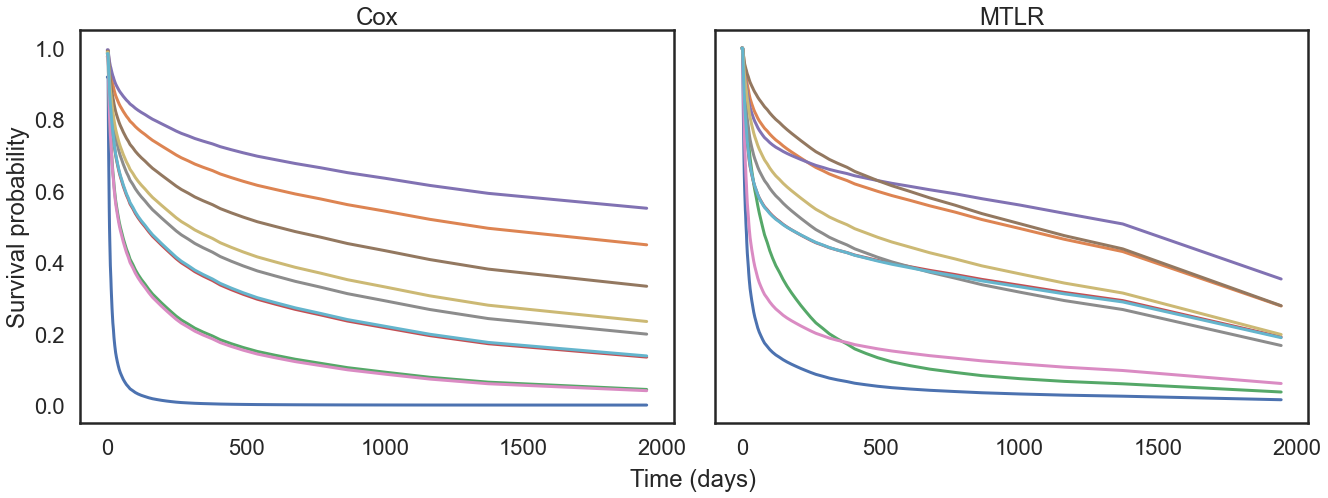

In [489]:
idxs = np.random.choice(np.arange(len(data_test)), 10)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(19, 7))

pred_survival_cph = cph.predict_survival_function(data_test, np.pad(time_bins, (1, 0))).values.T
pred_survival_mtlr = mtlr_survival(pred).cpu()

for idx in idxs:
    ax[0].plot(np.pad(time_bins, (1, 0)), pred_survival_cph[idx])
    ax[1].plot(np.pad(time_bins, (1, 0)), pred_survival_mtlr[idx])

ax[0].set_ylabel("Survival probability")
ax[1].set_ylabel("")
ax[0].set_title("Cox")
ax[1].set_title("MTLR")
fig.text(0.52,0.01, "Time (days)", ha="center", va="center")
fig.tight_layout()

### Visualising model parameters
To help interpret the predictions and find the most important features, we can plot the weight for each feature at each timepoint. Here we select the 5 features with the highest sum of absolute weight values over time. Again, the L2 regularisation strength determines the smoothness of weights. Notice how the importance of the variables changes over time, unlike the Cox model (where the hazard ratio for each covariate is constant over time).

The weights plot makes the model highly interpretable. Consider the plot below:
- Initially, being in coma (`scoma`) significantly increases the risk of dying. After a few days, patients in coma either recover or die, and the variable loses importance at later timepoints.
- Having cancer (`dzclass_Cancer`) does not seem to matter in the first few days, but becomes a strong risk factor later on. Moreover, metastatic cancer (`ca`) carries appropriately higher risk.

(you might see slightly different results if you re-run the training code multiple times).

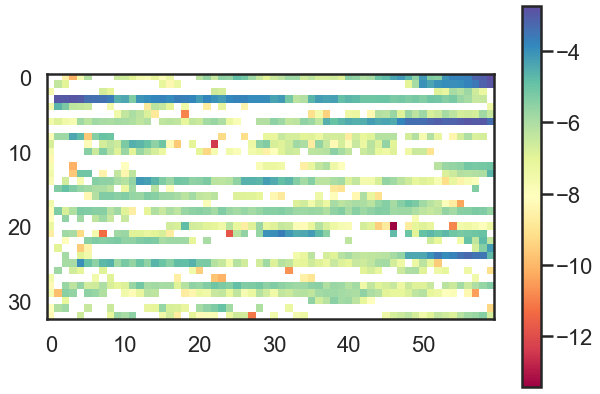

In [490]:
plt.imshow(mtlr.mtlr_weight.detach().log(), cmap="Spectral")
plt.colorbar()

In [486]:
torch.isclose(mtlr.mtlr_weight, torch.tensor(0.), atol=1e-5).sum()

tensor(5)

In [491]:
torch.isclose(mtlr.mtlr_weight, torch.tensor(0.), atol=1e-5).sum()

tensor(8)

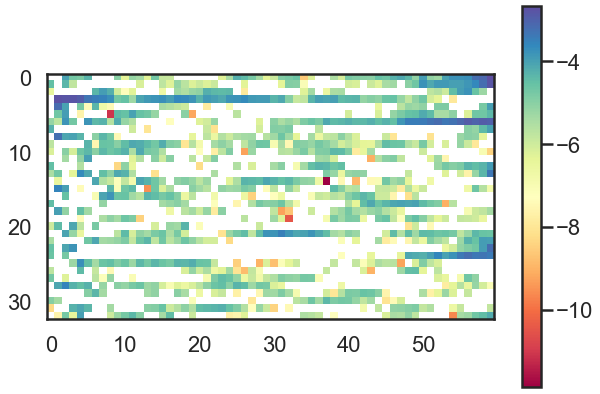

In [432]:
plt.imshow(mtlr.mtlr_weight.detach().log(), cmap="Spectral")
plt.colorbar()

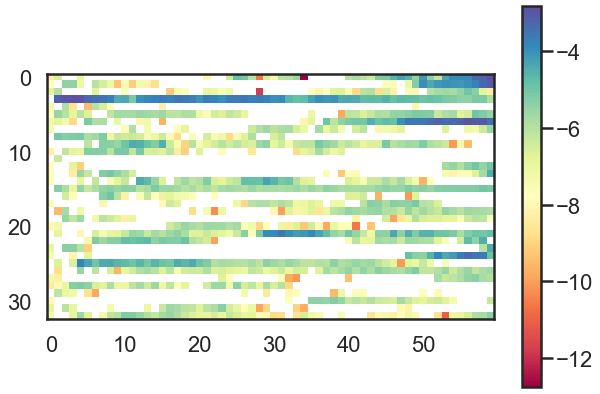

In [428]:
plt.imshow(mtlr.mtlr_weight.detach().log(), cmap="Spectral")
plt.colorbar()

<AxesSubplot:xlabel='Time (days)', ylabel='Weight'>

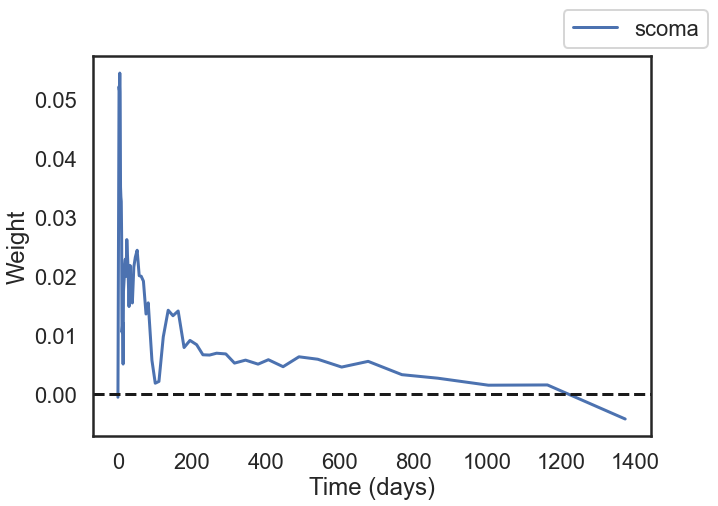

In [493]:
feature_names = data.drop(["time", "event"], axis=1).columns
plot_weights(mtlr.mtlr_weight.detach().cpu(), time_bins, feature_names, n=1)

## Deep MTLR
A cool aspect of MTLR is that it is differentiable end-to-end. This lets us increase the capacity of the model by using a neural net to learn nonlinear representations end-to-end with survival prediction. Simply stack a recognition network on top of the model and watch the autodiff magic happen!

In [19]:
# The MTLR module can be used just like any other PyTorch layer
mtlr = nn.Sequential(
    nn.Linear(num_features, 100),
    nn.ELU(),
    nn.Dropout(.4),
    nn.Linear(100, 32),
    nn.ELU(),
    nn.Dropout(.4),
    MTLR(in_features=32, num_time_bins=num_time_bins)
)

mtlr = train_mtlr_cv(mtlr, data_train, time_bins, num_epochs=500, lr=.005,
                     batch_size=512, cv=3, weight_decay=1e-5, verbose=True)

with torch.no_grad():
    pred = mtlr(torch.tensor(data_test.drop(["time", "event"], axis=1).values, dtype=torch.float))
    pred_survival = mtlr_survival_at_times(pred, np.pad(time_bins, (1, 0)), eval_times)

bs = brier_score_at_times(data_test["time"], pred_survival, data_test["event"], eval_times)
auc = roc_auc_at_times(data_test["time"], pred_survival, data_test["event"], eval_times)
metrics.append({
    "model": "deepmtlr",
    **{f"bs_{t}": bs[i] for i, t in enumerate(eval_times)},
    **{f"auc_{t}": auc[i] for i, t in enumerate(eval_times)}
})

[epoch    1/500]:   0%|          | 1/500 [00:00<01:00,  8.29it/s, loss = 3.3977]

training with l2_reg = 0.1


[epoch  500/500]: 100%|██████████| 500/500 [00:58<00:00,  8.61it/s, loss = 2.8451]


In [20]:
pd.DataFrame(metrics).round(3)

,model,bs_14,bs_58,bs_252,auc_14,auc_58,auc_252
0,cox,0.134,0.196,0.208,0.718,0.715,0.738
1,mtlr,0.126,0.191,0.213,0.777,0.735,0.723
2,deepmtlr,0.128,0.191,0.212,0.773,0.742,0.728


Using a neural net, we're able to achieve better classification accuracy and calibration than the linear model. The gains could be even bigger if we had a larger dataset to learn from.

## Visualising learned representations
We can inspect the learned features in the penultimate layer (just before the MTLR head) to see if the model is able to learn meaningful representations. We'll use [UMAP](https://arxiv.org/abs/1802.03426) to embed the learned features in 2 dimensions for visualisation.

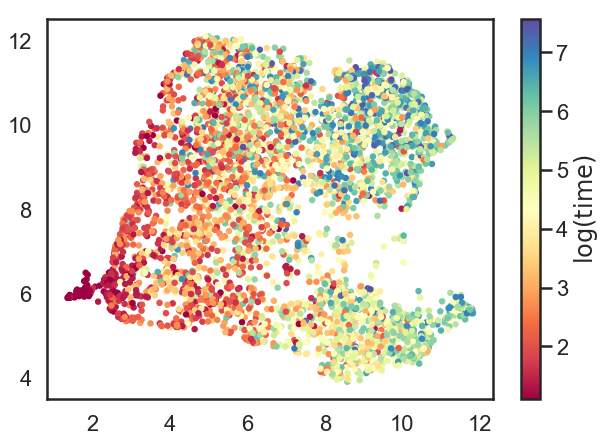

In [21]:
from umap import UMAP

uncensored = data_train.loc[data_train["event"] == 1]

with torch.no_grad():
    hidden = mtlr[:-1](torch.tensor(uncensored.drop(["time", "event"], axis=1).values, dtype=torch.float, device=device)).cpu().numpy()

umap = UMAP()
hidden_vis = umap.fit_transform(hidden)

plt.scatter(hidden_vis[:, 0], hidden_vis[:, 1], c=np.log(uncensored["time"]), s=20, cmap="Spectral")
plt.colorbar(label="$\log(\mathrm{time})$")

The samples seem to cluster by survival time in the embedding space, which seems to vary smoothly along the embedding dimensions. This means that the model is able to learn meaningful representations for survival prediction.

The potential of MTLR does not end here — since it's differentiable, it can be used like any other neural network layer, for example with an LSTM recognition network to handle time-varying features, or with a CNN stem to learn features directly from medical images (something I'm working on right now), or even something more exotic like a [neural ODE](https://papers.nips.cc/paper/8773-latent-ordinary-differential-equations-for-irregularly-sampled-time-series.pdf). 

## Useful resources and further reading
1. [The original NeurIPS publication](https://papers.nips.cc/paper/4210-learning-patient-specific-cancer-survival-distributions-as-a-sequence-of-dependent-regressors) for theoretical background and [Ping Jin's master's thesis](https://era.library.ualberta.ca/items/3deb4dd9-788d-4c61-94a5-d3ee6645f74f) for various implementation tricks, including reformulation as softmax classifier and proof that the second regulariser from the original paper is redundant.
2. [This paper](https://arxiv.org/abs/1801.05512) which is the first application of Deep MTLR (as far as I know).
3. [R implementation of MTLR](https://github.com/haiderstats/MTLR)
4. [PySurvival](https://square.github.io/pysurvival/) from Square has PyTorch implementations of both MTLR and Deep MTLR as well as other useful survival models.
5. [This paper](https://arxiv.org/abs/2003.08573v2) on Bayesian reformulation of Deep MTLR that allows for better handling of uncertainty and out-of-distribution samples.